# Pose clustering of docking results

In this Cheminformatics workflow I will show you how to perform a pose clustering from docking experiments (no matter what software they come from). For this workflow I will use RDKIT and the clustering will be based on The Cambridge Crystallographic Data Centre (CCDC) pose clustering analysis described in: ([GOLD_user_guide](https://www.ccdc.cam.ac.uk/support-and-resources/ccdcresources/GOLD_User_Guide.pdf))

#### Remarks:

Pose clustering is based on in place RMS calculation of the molecule poses. However, RDKIT cannot perform in place RMS calculations (yet). Because of that I will need to use another library (for instance Pymol) or calculate the RMS by applying the RMS formula ([wikipedia_RMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions)). 

For this workflow, I will use both and then I will discuss which is better for this approach (in my opinion).

## Importing the libraries

In [1]:
import os

# The powerful libraries from rdkit I will use:
from rdkit import Chem
from rdkit.Chem import rdFMCS,AllChem, Draw
from rdkit.Chem.Draw import DrawingOptions

# Other powerful python libraries:
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec

# We will use pymol for comparison
from pymol import cmd

# All we need for clustering
from scipy.cluster.hierarchy import dendrogram, linkage

## In place RMS calculation using RDKIT Maximum Common Substructure 

To get the atom mapping of our docking poses we will use the Maximum Common Substructure ([MCS](http://rdkit.org/docs/source/rdkit.Chem.MCS.html)) search module from RDKIT. For comparison with other RMS in place method, I will use pymol Rms_cur method ([Rms_cur](https://pymolwiki.org/index.php/Rms_cur)).

### Loading the poses

After docking I have a .sdf file for each molecule with 10 poses. I want to compare all my poses

In [2]:
poses=Chem.SDMolSupplier('ZINC12447282.sdf')
renamed_poses=[]
for index,p in enumerate(poses):
    p.SetProp('_Name',str(index+1))
    renamed_poses.append(p)

Let´s take a look to the 3D structures of my poses

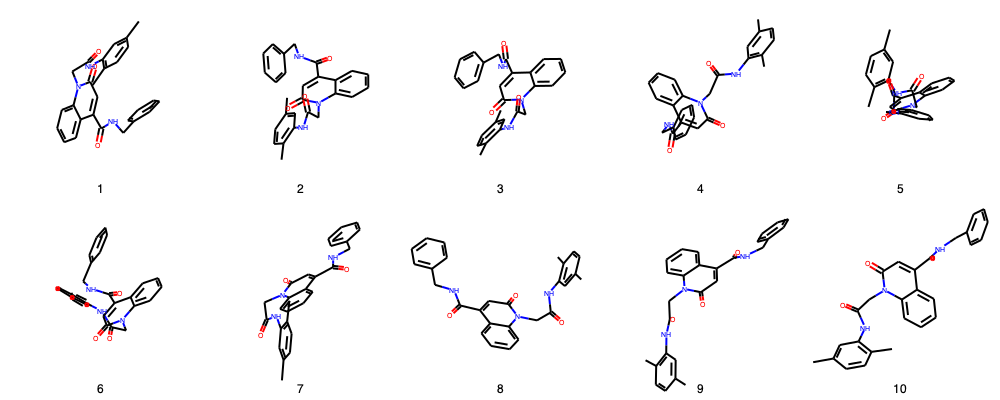

In [3]:
# If all molecules are correct (sanitized), Draw.MolsToGridImage must work 
img=Draw.MolsToGridImage(renamed_poses,molsPerRow=(5),legends=[i.GetProp('_Name') for i in renamed_poses],useSVG=False)
img

## RMS in place calculation

For an accurate RMS calculation we need to establish the atom pairs that will be used for RMS calculation. For such purpose I will use the MCS.

The idea of using the MCS is to generate the atom pairs for comparison. This is important, because atom mapping for poses of same molecule can be different in some cases. For instance, if they come from different docking softwares or due to format conversion (e.g. converting output mols from docking using openbabel).

Because of above, performing MCS will find the atom map matching pairs for the poses before of doing the RMS calculation.

For this example, all poses come from same docking software. As a consequence atoms are numerated in the same way in all poses. But this could be tricky if we use different softwares.

In [4]:
size=len(renamed_poses)
hmap=np.empty(shape=(size,size))
table=pd.DataFrame()
for i,mol in enumerate(renamed_poses):
    for j,jmol in enumerate(renamed_poses):
        # MCS identification between reference pose and target pose
        r=rdFMCS.FindMCS([mol,jmol])
        # Atom map for reference and target              
        a=mol.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
        b=jmol.GetSubstructMatch(Chem.MolFromSmarts(r.smartsString))
        # Atom map generation     
        amap=list(zip(a,b))
        
        # distance calculation per atom pair
        distances=[]
        for atomA, atomB in amap:
            pos_A=mol.GetConformer().GetAtomPosition (atomA)
            pos_B=jmol.GetConformer().GetAtomPosition (atomB)
            coord_A=np.array((pos_A.x,pos_A.y,pos_A.z))
            coord_B=np.array ((pos_B.x,pos_B.y,pos_B.z))
            dist_numpy = np.linalg.norm(coord_A-coord_B)        
            distances.append(dist_numpy)
                         
        # This is the RMSD formula from wikipedia
        rmsd=math.sqrt(1/len(distances)*sum([i*i for i in distances])) 
        
        #saving the rmsd values to a matrix and a table for clustering
        hmap[i,j]=rmsd
        table.loc[mol.GetProp('_Name'),jmol.GetProp('_Name')]=rmsd

We can find the RMS values of all comparison within the table.

In [5]:
table

,1,2,3,4,5,6,7,8,9,10
1,0.000000,11.672797,11.788448,10.828950,6.961153,10.433028,14.644619,10.846316,12.935449,11.614146
2,11.672797,0.000000,1.699091,10.285572,9.580073,2.826736,6.916287,7.743253,7.488534,6.121009
3,11.788448,1.699091,0.000000,10.392691,9.791194,3.300259,7.073445,7.936158,7.205426,6.554362
4,10.828950,10.285572,10.392691,0.000000,6.531423,9.941797,9.589811,5.922981,9.691021,9.448656
5,6.961153,9.580073,9.791194,6.531423,0.000000,8.714398,11.229659,7.780132,9.702039,8.521143
6,10.433028,2.826736,3.300259,9.941797,8.714398,0.000000,7.623271,7.419701,7.716591,6.322045
7,14.644619,6.916287,7.073445,9.589811,11.229659,7.623271,0.000000,8.454014,5.125215,4.790534
8,10.846316,7.743253,7.936158,5.922981,7.780132,7.419701,8.454014,0.000000,9.496095,8.573034
9,12.935449,7.488534,7.205426,9.691021,9.702039,7.716591,5.125215,9.496095,0.000000,4.256204
10,11.614146,6.121009,6.554362,9.448656,8.521143,6.322045,4.790534,8.573034,4.256204,0.000000


And also we can check if our RMS calculation is considering the full molecule, a fragment or substructure. 

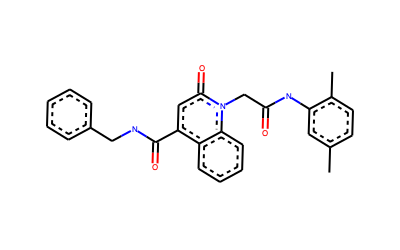

In [6]:
# Atoms that were used for RMSD calculation (Stereochemistry not shown)
DrawingOptions.bondLineWidth=2
DrawingOptions.includeAtomNumbers=False
structure=Draw.MolToImage(Chem.MolFromSmarts(r.smartsString),size=(400,250))
structure

Depending in what you want to do, you could be interested in performing an RMS calculation of just a fragment of the molecule. For such purpose you can modify the MCS search to get the atom pairs of the substructure for you are interested.

E.g.

To calculate the RMS for the quinoline 

a=mol.GetSubstructMatch(Chem.MolFromSmiles('C1=CC2=CC=CN=C2C=C1'))

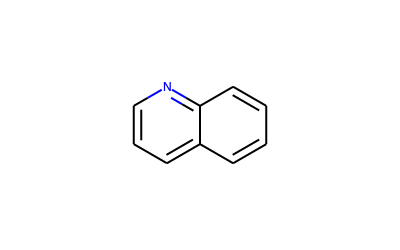

In [7]:
DrawingOptions.bondLineWidth=2
DrawingOptions.includeAtomNumbers=False
Draw.MolToImage(Chem.MolFromSmiles('C1=CC2=CC=CN=C2C=C1'),size=(400,250))

As a comparison, I will run the same RMS calculation but using Pymol instead of the formula

In [8]:
size=len(renamed_poses)
hmap=np.empty(shape=(size,size))
table=pd.DataFrame()
for i,mol in enumerate(renamed_poses):
    for j,jmol in enumerate(renamed_poses):
        
        #This is the Pymol Rms_cur implementation for in place calculation
        cmd.read_molstr(Chem.MolToMolBlock(mol),'ref')
        cmd.read_molstr(Chem.MolToMolBlock(jmol),'target')
        rmsd=cmd.rms_cur('ref','target',cycles=10,matchmaker=1)
        cmd.deselect()
        cmd.delete('all')
        
        hmap[i,j]=rmsd
        table.loc[mol.GetProp('_Name'),jmol.GetProp('_Name')]=rmsd

 PyMOL not running, entering library mode (experimental)


In [9]:
table

,1,2,3,4,5,6,7,8,9,10
1,0.000000,11.672796,11.788448,10.828950,6.961154,10.433027,14.644619,10.846315,12.935449,11.614147
2,11.672796,0.000000,1.699092,10.285572,9.580073,2.826735,6.916287,7.743253,7.488534,6.121009
3,11.788448,1.699092,0.000000,10.392691,9.791193,3.300258,7.073445,7.936158,7.205426,6.554362
4,10.828950,10.285572,10.392691,0.000000,6.531424,9.941796,9.589811,5.922981,9.691021,9.448656
5,6.961154,9.580073,9.791193,6.531424,0.000000,8.714397,11.229659,7.780132,9.702039,8.521143
6,10.433027,2.826735,3.300258,9.941796,8.714397,0.000000,7.623271,7.419702,7.716590,6.322044
7,14.644619,6.916287,7.073445,9.589811,11.229659,7.623271,0.000000,8.454015,5.125215,4.790534
8,10.846315,7.743253,7.936158,5.922981,7.780132,7.419702,8.454015,0.000000,9.496095,8.573033
9,12.935449,7.488534,7.205426,9.691021,9.702039,7.716590,5.125215,9.496095,0.000000,4.256204
10,11.614147,6.121009,6.554362,9.448656,8.521143,6.322044,4.790534,8.573033,4.256204,0.000000


As you can see, values from RMS formula and Pymol Rms_cur are the same. However, for this calculation Pymol generates the atom selection by turning on the option **matchmaker=1**. In my experience, when working with poses from different softwares. Pymol Rms_cur can fail even with matchmaker=1. So I would advice to use it carefully and corroborate the RMS values by using the MCS from RDKIT.

## Pose clustering

As I refer before, this analysis will be based on the GOLD clustering of poses from the CCDC. Therefore, we need to use a complete linkage hierarchical clustering algorithm (HCL). This can be easy doing by typing:

In [10]:
# I will use the matrix that I generated before
linked = linkage(hmap,'complete')
labelList = [mol.GetProp('_Name') for mol in renamed_poses]
# Don´t worry about the warning, the analysis was done

/Users/angel/miniconda3/envs/Cheminformatics/lib/python3.6/site-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


A simple plot of the HCL

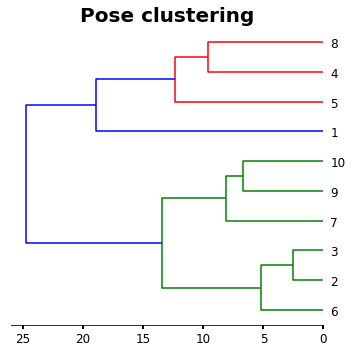

In [11]:
plt.figure(figsize=(5,5))

ax1=plt.subplot()
o=dendrogram(linked,  
            orientation='left',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)

ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.title('Pose clustering',fontsize=20,weight='bold')
plt.tick_params ('both',width=2,labelsize=12)
plt.tight_layout()
plt.show() 

For more clearance we will interested in see a heatmap of the poses next to the HCL

In [12]:
# This will give us the clusters in order as the last plot

new_data=list(reversed(o['ivl']))

# we create a new table with the order of HCL
hmap_2=np.empty(shape=(size,size))
for index,i in enumerate(new_data):
    for jndex,j in enumerate(new_data):
        hmap_2[index,jndex]=table.loc[i].at[j]

And now a super fancy and useful plot

[]

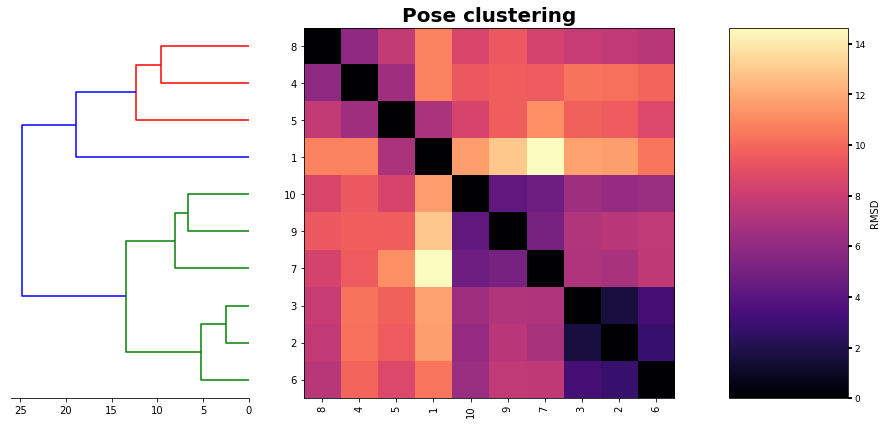

In [15]:
figure= plt.figure(figsize=(15,15))
gs1 = gridspec.GridSpec(2,7)
gs1.update(wspace=0.01)
ax1 = plt.subplot(gs1[0:-1, :2])
dendrogram(linked, orientation='left', distance_sort='descending',show_leaf_counts=True,no_labels=True)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.subplot(gs1[0:-1,2:6])
f=ax2.imshow (hmap_2, cmap='magma', interpolation='nearest')

ax2.set_title('Pose clustering',fontsize=20,weight='bold')
ax2.set_xticks (range(len(new_data)))
ax2.set_yticks (range(len(new_data)))
ax2.set_xticklabels (new_data,rotation=90)
ax2.set_yticklabels (new_data)

ax3 = plt.subplot(gs1[0:-1,6:7])
m=plt.colorbar(f,cax=ax3,shrink=0.75,orientation='vertical',spacing='uniform',pad=0.01)
m.set_label ('RMSD')

plt.tick_params ('both',width=2,labelsize=9)
plt.plot()

.. disqus::